# Automates finis - TP 4

### Objectif du TP

L'objectif de ce dernier TP est d'écrire un programma capable de reconnaître si un mot quelconque peut être reconnu par une expression régulière quelconque. Pour cela, nous allons utiliser ce que nous avons développé jusque là :
  * Opérations régulières (TP3) pour implémenter l'algorithme de Moore,
  * Déterminisation (TP2) pour déterminiser l'automate résultant, puis
  * Reconnaissance (TP1) pour savoir si le mot est reconnu par l'automate déterminisé.
Vous allez donc faire un programme qui parcours une expression régulière donnée, crée un automate fini à partir de cette expression, et ensuite déterminise et simule cet automate pour donner la réponse `YES` si le mot est reconnu et `NO` sinon.

### Rappel : expressions régulières

Une expression régulière est composée d'éléments atomiques et d'opérateurs, ainsi que de parenthèses pour changer la precédence de ces opérateurs. 

Les éléments atomiques sont :
  * L'ensemble vide qui dénote le langage vide (dans ce TP, nous ne modéliserons pas l'ensemble vide)
  * Le symbole spécial "mot vide" $\varepsilon$, ici représenté par le caractère spécial `%`
  * Des symboles simples de l'alphabet, ici représentés par des lettres et des chiffres p.ex. `a`, `b`, `1`, `2`
  
Les opérateurs sont :
  * L'union, notée avec un `+`, p.ex. `a+b` dénote le langage contenant les symboles `a` ou `b`
  * La concaténation, notée simplement par la juxtaposition des éléments p.ex. `ab` dénote `a` concaténé à `b`  
  * L'étoile de Kleene `*` représente l'auto-concaténation un nombre arbitraire de fois p.ex. `a*`
  
**Priorité des opérateurs**: L'étoile de Kleene est plus prioritaire que la concaténation qui est à son tour plus prioritaire que l'union. Ainsi, l'expression `c+ab*` doit être interprétée comme `c+(a(b*))`, c'est-à-dire on applique d'abord `*` au symbole qui la précède `b`, puis on concatène le résultat avec le `a` qui précède, et en dernier on effectue l'union avec `c`. Si on veut changer cette priorité pour effectuer d'abord l'union, ensuite la concaténation, et appliquer en dernier l'étoile de Kleene sur le tout, on doit écrire avec des parenthèses `((c+a)b)*`. Notez que c'est l'expression la plus imbriquée dans les parenthèses qui est effectuée d'abord.
  
### Expressions régulières en notation postfixée
  
**Notation infixée et parenthèses**: Les opérateurs de concaténation et d'union sont infixés, c'est à dire ils apparaîssent _au milieu_ des deux opérandes. Ainsi, `a+b` contient l'opérande gauche `a`, l'opérateur `+`, et l'opérande droite `b`. Ce format n'est pas très pratique à analyser car il requiert des parenthèses pour forcer un certain ordre d'application des opérateurs. L'étoile de Kleene, au contraire, est postfixée, c'est-à-dire, elle apparaît _après_ l'opérande et s'applique sur le symbole ou expression parenthésée qui est à sa gauche. 

**Notation postfixée**: Pour travailler avec les expressions régulières dans ce TP, la présence de parenthèses et la notation infixée n'est pas pratique car elle requiert une analyse syntaxique complexe de l'expression régulière (vous allez apprendre à faire cela en cours de Compilation en L3). Pour vous faciliter la tâche, nous travaillerons avec la notation postfixée. Cette notation met l'opérateur toujours en dernier, après les deux opérandes (ou une, dans le cas de l'étoile de Kleene). Par exemple `a+b` en notation infixée s'écrit `ab+`. On sait que `+` est un opérateur binaire, donc on sait qu'il s'applique aux deux dernières opérandes à sa gauche. Dans cette notation, la concaténation est explicitement notée via le symbole point final `.`. Par exemple, `abc..` se lit `b` concaténé à `c`, et le résultat de cette concaténation `bc` concaténé à `a`, c'est-à-dire `abc`.

**Absence de parenthèses**: Le grand avantage de la notation postfixée par rapport à la notation infixée c'est qu'elle ne nécessite pas de parenthèses. Par exemple, `c+(a(b*))` en notation postfixée donne `cab*.+`, c'est-à-dire, on applique d'abord `*` à `b`, puis on concatène `a` avec ce `b*`, pour finalement faire l'union de `c` avec `ab*`. Si on voulait changer l'ordre de priorité et forcer une lecture comme dans `((c+a)b)*`, on peut tout simplement écrire `ca+b.*`, c'est-à-dire dès qu'on trouve `+`, on fait l'union `c+a`. Cette dernière est ensuite concaténée à `b` pour former `(c+a)b` et finalement l'étoile de Kleene est appliqueé à ce résultat.

**RegExpReader**: La conversion d'une expression régulière en notation infixée (comme vous les écrivez habituellement) vers une notation postfixée est fournie dans la bibliothèque `automaton.py`. La fonction à appeler est `automaton.RegExpReader("a+b").to_postfix()` où `a+b` représente l'expression à convertir. Prenez maintenant le temps de tester quelques expressions régulières et de voir comment on écrit la version postfixée (que vous allez manipuler) par rapport à la notation infixée (à laquelle vous êtes habitué.e.s)

In [1]:
import automaton
# ajouter vos regexp ici pour tester la conversion...
regexp_list = ["a+b", "a+b*", "a*+b*", "ab*+a*b", "(a+b)*(a+b)*", "a+b*a+b*", "(a+%)b*"] 
for infix in regexp_list :
    postfix = automaton.RegExpReader(infix).to_postfix()
    print ("Notation infixée   : \"{}\"".format(infix))    
    print ("Notation postfixée : \"{}\"\n".format(postfix))


Notation infixée   : "a+b"
Notation postfixée : "ab+"

Notation infixée   : "a+b*"
Notation postfixée : "ab*+"

Notation infixée   : "a*+b*"
Notation postfixée : "a*b*+"

Notation infixée   : "ab*+a*b"
Notation postfixée : "ab*.a*b.+"

Notation infixée   : "(a+b)*(a+b)*"
Notation postfixée : "ab+*ab+*."

Notation infixée   : "a+b*a+b*"
Notation postfixée : "ab*a.b*++"

Notation infixée   : "(a+%)b*"
Notation postfixée : "a%+b*."



### Lecture et traitement d'une expression régulière postfixée

**La pile**: Une expression régulière postfixée peut être facilement traitée à l'aide d'une structure de données de type [_pile_](https://fr.wikipedia.org/wiki/Pile_(informatique)). Une pile est une liste à laquelle on ne peut qu'ajouter ou enlever des éléments au bout, jamais au milieu. Les listes python peuvent être utilisées directement comme des piles à l'aide des fonctions `append(a)` et `pop()`. La fonction `append(a)` ajoute un élément à la fin de la liste, que nous appellerons le _sommet_ de la pile (car une pile est généralement dessinée à la verticale, ave le sommet tout en haut. Comme dans une vraie pile d'objets, on ne peut pas ajouter ou supprimer des éléments au milieu, mais uniquement au sommet). L'opération `pop()` supprime et renvoie le dernier élément de la pile, c'est-à-dire le _sommet_. Voici un exemple de liste python utilisée comme pile:

In [2]:
pile = []
print("J'ajoute trois éléments 'a', 'b', 'c' à la pile dans cet ordre")
pile.append("a")
pile.append("b")
pile.append("c")
print("Maintenant, 'c' est au sommet de la pile, 'b' est juste en dessous, et 'a' est à la base")
print(pile)
print("Le sommet de la pile est la position -1, c'est-à-dire la première en partant de la fin")
print(pile[-1])
print("Si je 'pop' la pile...")
sommet = pile.pop()
print("Le sommet renvoyé est le dernier élément ajouté.")
print(sommet) 
print("et il ne reste que deux éléments dans la pile")
print(pile) 
print("Je re-'pop' et maintenant j'obtient un 'b' comme sommet")
sommet = pile.pop()
print(sommet)
print("Le dernier élément que je peux 'pop' est 'a'")
sommet = pile.pop()
print(sommet)
print("Désormais la pile est vide et si j'appellais 'pop' cela renverrait une erreur (essayez !)")
print(pile)
#pile.pop()
print("Remarquez que les élements sont 'pop'és dans l'ordre inverse où ils ont été 'append'és")

J'ajoute trois éléments 'a', 'b', 'c' à la pile dans cet ordre
Maintenant, 'c' est au sommet de la pile, 'b' est juste en dessous, et 'a' est à la base
['a', 'b', 'c']
Le sommet de la pile est la position -1, c'est-à-dire la première en partant de la fin
c
Si je 'pop' la pile...
Le sommet renvoyé est le dernier élément ajouté.
c
et il ne reste que deux éléments dans la pile
['a', 'b']
Je re-'pop' et maintenant j'obtient un 'b' comme sommet
b
Le dernier élément que je peux 'pop' est 'a'
a
Désormais la pile est vide et si j'appellais 'pop' cela renverrait une erreur (essayez !)
[]
Remarquez que les élements sont 'pop'és dans l'ordre inverse où ils ont été 'append'és


**Lecture d'une expression avec la pile**: quel est le rapport de la pile avec l'expression  régulière en notation postfixée ? À l'aide d'une pile, traiter et évaluer l'expression régulière devient simple. Vous lirez l'expression régulière postfixée de gauche à droite :
  * Si vous tombez sur un symbole simple (chiffre, lettre, ou mot vide `%`), vous créerez un automate élémentaire qui reconnaît ce symbole et vous l'empilerez (oui oui, on va faire une pile d'automates... c'est beau non ?)
  * Si vous tombez sur un opérateur parmi `+.*`, vous l'appliquerez aux deux éléments (ou un élément pour `*`) qui se trouvent au sommet de la pile, puis vous empilerez (`append`) le résultat. 
Si vous suivez ces deux règles simples, à la fin de la lecture de l'expression postfixée la pile contientra un seul élément, qui est l'automate correspondant à l'expression régulière postfixée lue. Autrement dit, vous implémenterez de cette façon l'algorithme de Thompson, qui permet de convertir une expression régulière en un automate fini non déterministe (plein de transitions-$\varepsilon$). 

**Application des opérateurs** Pour l'algorithme ci-dessus, "appliquer" un opérateur signifie créer un automate fini qui combine deux autres automates sur la pile, comme dans l'algorithme de Thompson. Pour cela, il suffira d'utiliser les opérations `union`, `concat` et `kleene` implémentées au TP3. Voyons un exemple concret de cet algorithme en action.

Supposons l'expression régulière `(a+%)b*` ci-dessus, qui s'écrit en notation postfixée `a%+b*.`. Nous initialiserons aussi la pile à vide:

In [3]:
pile = []
postfix = automaton.RegExpReader("(a+%)b*").to_postfix()
print(postfix)

a%+b*.


Le premier symbole de cette expression est un `a`. Ainsi, nous devons créer un automate qui reconnaît `a` et l'empiler :

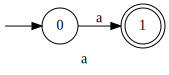

In [4]:
a = automaton.Automaton("a")
a.add_transition("0","a","1")
a.make_accept("1")
pile.append(a)
pile[-1] # La pile contient l'automate qui reconnaît 'a'

Le deuxième symbole est maintenant un `%` qui représente $\varepsilon$. De manière analogue, nous construisons un automate pour reconnaître $\varepsilon$ puis nous l'empilons (il vaut mieux faire une fonction qui construit un automate élémentaire pour un symbole quelconque, lettre, chiffre, ou `%`):

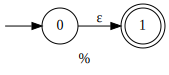

In [5]:
e = automaton.Automaton("%")
e.add_transition("0","%","1")
e.make_accept("1")
pile.append(e)
pile[-1]

La pile contient maintenant deux éléments : l'automate qui reconnaît `a`, et au dessus, au sommet, l'automate qui reconnaît $\varepsilon$. Le troisième symbole dans l'expression postfixée est `+`, cela veut dire qu'il faut dépiler les deux derniers éléments, appliquer l'union (avec le sommet à droite et l'élément juste en dessous du sommet à gauche) puis empiler le résultat :

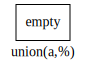

In [6]:
droite = pile.pop()
gauche = pile.pop()
#resultat = union(gauche,droite) # implémenté en TP3
nom = "union({},{})".format(gauche.name,droite.name)
resultat = automaton.Automaton(nom)
pile.append(resultat)
pile[-1]

Vous avez implémenté une fonction qui fait l'union entre deux automates quelconques, que vous appelerez ici (commentée ci-dessus). Nous ne pouvons pas l'appliquer car elle n'est pas fournie dans `automaton.py`. Pour cet exemple, nous créons un automate bidon vide, mais dont le nom indique qu'il est l'union entre deux automates. Il faut nous croire : ça marchera avec votre fonction `union` (à condition qu'elle n'ait pas de bug -- sinon c'est l'occasion de les corriger).

Le quatriéme symbole de l'expression `a%+b*.` est un `b`. Il faut donc empiler un automate qui reconnaît `b` :

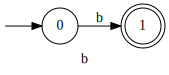

In [7]:
b = automaton.Automaton("b")
b.add_transition("0","b","1")
b.make_accept("1")
pile.append(b)
pile[-1] 

La pile contient désormais l'automate qui reconnaît `a+%` à la base, et `b` au sommet:

In [8]:
for (i,a) in enumerate(pile):
    print("Position {}".format(i))
    print(str(a))
    print()

Position 0
union(a,%) = <Q={}, S={}, D, q0=None, F={}>
D =
| |
---

Position 1
b = <Q={0,1}, S={b}, D, q0=0, F={1}>
D =
| |b|
-----
|0|1|
-----
|1| |
-----



Le cinquième symbole est l'étoile de Kleene. Encore une fois, nous ne pouvons pas l'appliquer ici directement mais nous créerons un automate bidon pour représenter l'application de la fonction que vous avez implémenté en TP3:

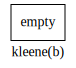

In [9]:
gauche = pile.pop()
#resultat = kleene(operande) # vous avez implementé cette fonction, pas nous :-/
nom = "kleene({})".format(gauche.name)
resultat = automaton.Automaton(nom)
pile.append(resultat)
pile[-1]

La pile contient désormais les automates qui reconnaîssent `a+%` en position 0 et `b*` en position 1 (sommet). Le sixième et dernier opérateur est un point `.` qui représente la concaténation de ces deux derniers automates, avec le sommet à droite et l'élément juste au dessous du sommet à gauche, comme pour l'union. Attention, la concaténation n'est pas commutative, c'est pour cela que nous insistons sur l'ordre, car on dépile dans l'ordre _inverse_ qu'on a empilé. Ainsi, notre dernière opération laisse sur le sommet de la pile l'automate résultant de la conversion :

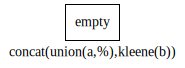

In [10]:
droite = pile.pop()
gauche = pile.pop()
#resultat = concat(gauche,droite) # implémenté en TP3
nom = "concat({},{})".format(gauche.name,droite.name)
resultat = automaton.Automaton(nom)
pile.append(resultat)
pile[-1]

### One script to rule them all

Il ne vous reste plus qu'à mettre ensemble tout ce que vous avez implémenté aux TP précédents. L'automate résultant de la conversion est (hautement) non déterministe. Vous devez le déterminiser en supprimant les transitions-$\varepsilon$, puis en appliquant la réduction des transitions (TP2). Finalement, vous devez appliquer la reconnaissance au mot passé en deuxième paramètre du script `sys.argv[2]` et dire `YES` ou `NO` si le mot est reconnu par l'expression régulière (TP1). Et voilà, la boucle est bouclée, il n'y a plus qu'à documenter et tester. Beaucoup tester !

### Documentation et tests

**Documentation**: Ce dernier TP est noté. Ainsi, il faut rendre la tâche des évaluatrices et évaluateurs la plus simple possible. Pour cela, vous avez un minimum de documentation à fournir. Cela consiste en :
  * Un fichier `README.txtx` ou `README.md` contenant
    1. **IMPORTANT!** Le NOM et Prénom des membres du binôme
    2. Des instructions pour exécuter votre programme/script à la ligne de commande, avec un exemple
    3. Si il faut installer des bibliothèques ou des dépendances autres que python3+graphviz, indiquer la procédure
    4. Si votre rendu est incomplet, expliquer jusqu'où vous êtes allé.e (et pourquoi)
    5. Indiquer toute partie du code qui aurait été copiée d'ailleurs ou faire en groupe (en dehors des binômes). Vous n'êtes pas censé copier-coller du code d'autres binômes, mais si jamais vous le faites il vaut mieux être honnête (et perdre quelques points) plutôt que le cacher (et risquer une procédure administrative pour plagiat, ce qui est très sérieux)
  * Un code-source minimalement organisé avec toutes les dépendances incluses et, si possible, quelques commentaires dans les fonctions principales, là où ça vous semble nécessaire (`automaton.py` est un exemple de documentation minimale, faites à peu près pareil)
  
Ne passez pas des heures à documenter chaque variable, chaque ligne, le plus important c'est qu'on puisse comprendre globalement l'idée derrière vos fonctions.
  
**Tests**: il faut suivre **précisément** les consignes ci-dessous pour votre script. Il doit lire l'expression régulière et le mot à reconnaître des arguments de la ligne de commande, et pas ailleurs. Il ne doit écrire rien d'autre que "YES" ou "NO" sur le terminal. Pas de "print" de débogage, pas d'automate dessiné, rien, juste "YES" ou "NO" tout en majuscules avec un saut de ligne à la fin (ajouté automatiquement par le "print" python).

Nous testerons votre programme de manière automatique. Autrement dit, nous passerons une batterie de tests composés d'expressions régulières + mots - résultat attendu "YES" ou "NO". Le nombre de tests réussis par votre programme constituera une partie de votre note.

Si votre TP est incomplet et vous n'arrivez pas à faire le TP4, par exemple, mais que vous avez fait les TP1, 2 et 3, signalez-le dans votre `README`. Nous évaluerons les 3 TP faits, et votre note maximale sera d'environ 3/4 de la note maximale complète, c'est-à-dire vous serez noté.e.s sur 15 au lieu de 20, et ainsi de suite si vous n'avez fait que le TP1 (5 points max) ou TP1-TP2 (10 points max). Dans ce cas, l'évaluation automatique n'est pas prise en compte.

# Travail à effectuer

Vous devez implémenter un script `tp4automates.py` qui, étant donné une expression régulière (`sys.argv[1]`) et un mot à reconnaître (`sys.argv[2]`), affiche sur `stdout` le mot `YES` si le mot est reconnu par l'expression régulière, et `NO` dans le cas où le mot n'est pas reconnu par l'expression régulière. Voici quelques exemples :
```bash
$ ./tp4automates.py a*+b* aaa
YES
$ ./tp4automates.py a*+b* %
YES
$ ./tp4automates.py a*+b* b
YES
$ ./tp4automates.py a*+b* aaa%
YES
$ ./tp4automates.py a*+b* ab
NO
$ ./tp4automates.py a*+b* aa%bb
NO
$ ./tp4automates.py a*+b* AAA
NO
```

Un squelette de programme principal est donné dans `tp4automates.py`. Vous pouvez l'utiliser comme point de départ. 